<h2>2<sup>η</sup> ΕΡΓΑΣΤΗΡΙΑΚΗ ΑΣΚΗΣΗ</h2>
<h3>Ανάλυση Κοινωνικής Δομής σε Τεχνητές και Πραγματικές Σύνθετες Τοπολογίες Δικτύων</h3>
<p style=text-align:justify>Στην παρούσα άσκηση θα αναλυθούν τεχνητές και πραγματικές τοπολογίες σύνθετων δικτύων με βάση τις μετρικές που χρησιμοποιήθηκαν στην προηγούμενη άσκηση και κάποιες τεχνικές που έχουν ως στόχο την εύρεση κοινωνικής δομής. Συγκεκριμένα, θα χρησιμοποιηθούν και θα συγκριθούν διάφοροι αλγόριθμοι εντοπισμού κοινοτήτων σε γράφους δικτύων που προκύπτουν από πραγματικά δεδομένα καθώς και στους συνθετικούς γράφους της πρώτης εργαστηριακής άσκησης.</p>

In [1]:
from itertools import takewhile
import statistics
import csv
import time

import networkx as nx
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import SpectralClustering
from networkx.algorithms.community import girvan_newman, modularity, performance, greedy_modularity_communities

<h3>Α. Μελέτη πραγματικών τοπολογιών</h3>
<p style=text-align:justify>Στο παρόν ερώτημα θα μελετήσετε και θα αποκτήσετε αίσθηση της τοπολογικής δομής πραγματικών δικτύων. Πιο συγκεκριμένα, για τις τοπολογίες που φαίνονται στον <b>πίνακα 1</b>, να βρεθούν και να δειχθούν:</p>
<ol>
    <li>Η κατανομή του βαθμού κόμβου και ο μέσος βαθμός κάθε τοπολογίας.</li>
    <li>Η κατανομή του συντελεστή ομαδοποίησης κόμβου και ο μέσος συντελεστής ομαδοποίησης κάθε τοπολογίας.</li>
    <li>Η κατανομή της κεντρικότητας εγγύτητας και η μέση κεντρικότητα εγγύτητας κάθε τοπολογίας.</li>
</ol>
<p style=text-align:justify>Να συγκριθούν τα αποτελέσματα σε σχέση με αυτά των συνθετικών τοπολογιών. Να χαρακτηρίσετε τον τύπο κάθε μίας από τις πραγματικές τοπολογίες με βάση τους τύπους δικτύων που εξετάστηκαν στην πρώτη εργαστηριακή άσκηση.</p>

<table style=width:100%>
    <caption>Πίνακας <b>1</b>: Πραγματικές τοπολογίες</a></caption>
<tr>
    <th style=text-align:left>Τοπολογία</th>
    <th style=text-align:left>Αρχείο</th>
    <th style=text-align:left>Περιγραφή</th>
</tr>
<tr>
    <td style=text-align:left>American College Football</td>
    <td style=text-align:left><a style=text-decoration:none href='http://www-personal.umich.edu/~mejn/netdata/football.zip'>football.gml</a></td>
    <td style=text-align:left><p style=text-align:justify> The file <b>football.gml</b> contains the network of American football games between Division IA colleges during regular season Fall 2000, as compiled by M. Girvan and M. Newman. The nodes have values that indicate to which conferences they belong.</p>
    </td>
</tr>  
<tr>
    <td style=text-align:left>Game of Thrones - season 5</td>
    <td style=text-align:left><a style=text-decoration:none href='https://networkofthrones.wordpress.com/the-series/season-5/'>GoT</a></td>
    <td style=text-align:left><p style=text-align:justify> The season 5 <b>GoT</b> network represents the interactions between the characters of Game of Thrones in season 5. The season 5 network has 118 nodes (characters) and 394 weighted edges, corresponding to 5,139 interactions. Data can be found here: <a style=text-decoration:none href='https://raw.githubusercontent.com/mathbeveridge/gameofthrones/master/data/got-s5-edges.csv'>GoT_data</a></p>
</tr> 
<tr>
    <td style=text-align:left>email-Eu-core</td>
    <td style=text-align:left><a style=text-decoration:none href='https://snap.stanford.edu/data/email-Eu-core.html'>email-eu-core</a></td>
    <td style=text-align:left><p style=text-align:justify> The network <b>email-Eu-core</b> was generated using email data from a large European research institution. There is an edge (u, v) in the network if person u sent person v at least one email. The e-mails only represent communication between institution members (the core) and the dataset does not contain incoming messages from or outgoing messages to the rest of the world. The dataset also contains "ground-truth" community memberships of the nodes. Each individual belongs to exactly one of 42 departments at the research institute. </p>
</tr> 
    
</table>

<h4>Παραγωγή συνθετικών τοπολογιών</h4> 
<p>Προσοχή! Τα δίκτυα που θα παράξετε θα πρέπει να είναι συνδεδεμένα.</p>

In [2]:
n = 80
d = 4
M = 300
R = 0.25
p = 0.3
k = 4
seed = 5

REG = nx.watts_strogatz_graph(n=n, k=d, p=0.0, seed=seed)
RGER = nx.gnm_random_graph(n=n, m=M, seed=seed)
RGG = nx.random_geometric_graph(n=n, radius=R, seed=seed)
SF = nx.barabasi_albert_graph(n=n, m=d, seed=seed)
SW = nx.watts_strogatz_graph(n=n, k=d, p=p, seed=seed)

graphs: dict[str, nx.Graph] = {'REG': REG, 'RG(ER)': RGER, 'RGG': RGG, 'SF(BA)': SF, 'SW(WS)': SW}

assert all(map(nx.is_connected, graphs.values()))

<h4>Εισαγωγή και οπτικοποίηση πραγματικών τοπολογιών.</h4>

In [3]:
#football network
football = nx.read_gml("football.gml")

graphs['football'] = football

In [4]:
#Game of thrones network
got = nx.Graph()

with open('got_s5.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    next(csv_reader)
    for row in csv_reader:
        got.add_edge(row[0], row[1])
        line_count += 1

graphs['got'] = got

#### Προσοχή! Θα μελετήσετε τη μεγαλύτερη συνδεδεμένη συνιστώσα του δικτύου email-Eu-core, αφού πρώτα αφαιρέσετε τα self-loops. Μπορείτε να κάνετε χρήση των συναρτήσεων connected_components, subgraph, remove_edges_from του networkx.

In [5]:
# email-Eu-core network
eu: nx.Graph = nx.read_edgelist("email-Eu-core.txt", create_using=nx.Graph())

print(eu)
eu.remove_edges_from(nx.selfloop_edges(eu))
print(eu)
eu = nx.subgraph(eu, max(nx.connected_components(eu), key=len))
print(eu)

graphs['eu'] = eu

Graph with 1005 nodes and 16706 edges
Graph with 1005 nodes and 16064 edges
Graph with 986 nodes and 16064 edges


<h4>Μελέτη βαθμού κόμβου για πραγματικές και συνθετικές τοπολογίες.</h4>

In [6]:
# LAB1 IMPORTS
HIST_PARAMS = dict(ec='#090c0e', fc='#8ebad9')


def plot_clustering_coefficient_distribution(G, name, nbins=30, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    cc = nx.clustering(G)
    mean = statistics.mean(cc.values())
    var = statistics.variance(cc.values())
    argmin = min(cc, key=cc.get)
    argmax = max(cc, key=cc.get)

    bins = np.linspace(0, 1, nbins + 1)
    ax.hist(cc.values(), bins=bins, **HIST_PARAMS)
    ax.set_title(f'{name}\nmean={mean:.2f}, var={var:.4f}\nargmin={argmin}, argmax={argmax}', fontsize=10)


def plot_centrality_distribution(centrality_fn, nbins=40):

    def inner(G, name, nbins=nbins, ax=None):
        if ax is None:
            _, ax = plt.subplots()

        centralities = centrality_fn(G).values()
        mean = statistics.mean(centralities)
        var = statistics.variance(centralities)

        bins = np.linspace(0, 1, nbins + 1)
        ax.hist(centralities, bins=bins, **HIST_PARAMS)
        ax.set_title(f'{name}\nmean={mean:.2f}, var={var:.4f}')

    return inner


def plot_grid(graphs, plot_fn, suptitle):
    assert len(graphs) <= 8
    fig, axs = plt.subplots(4, 2, figsize=(10, 25))

    for (name, G), ax in zip(graphs.items(), axs.flat):
        plot_fn(G, name, ax=ax)

    fig.suptitle(suptitle)
    return axs

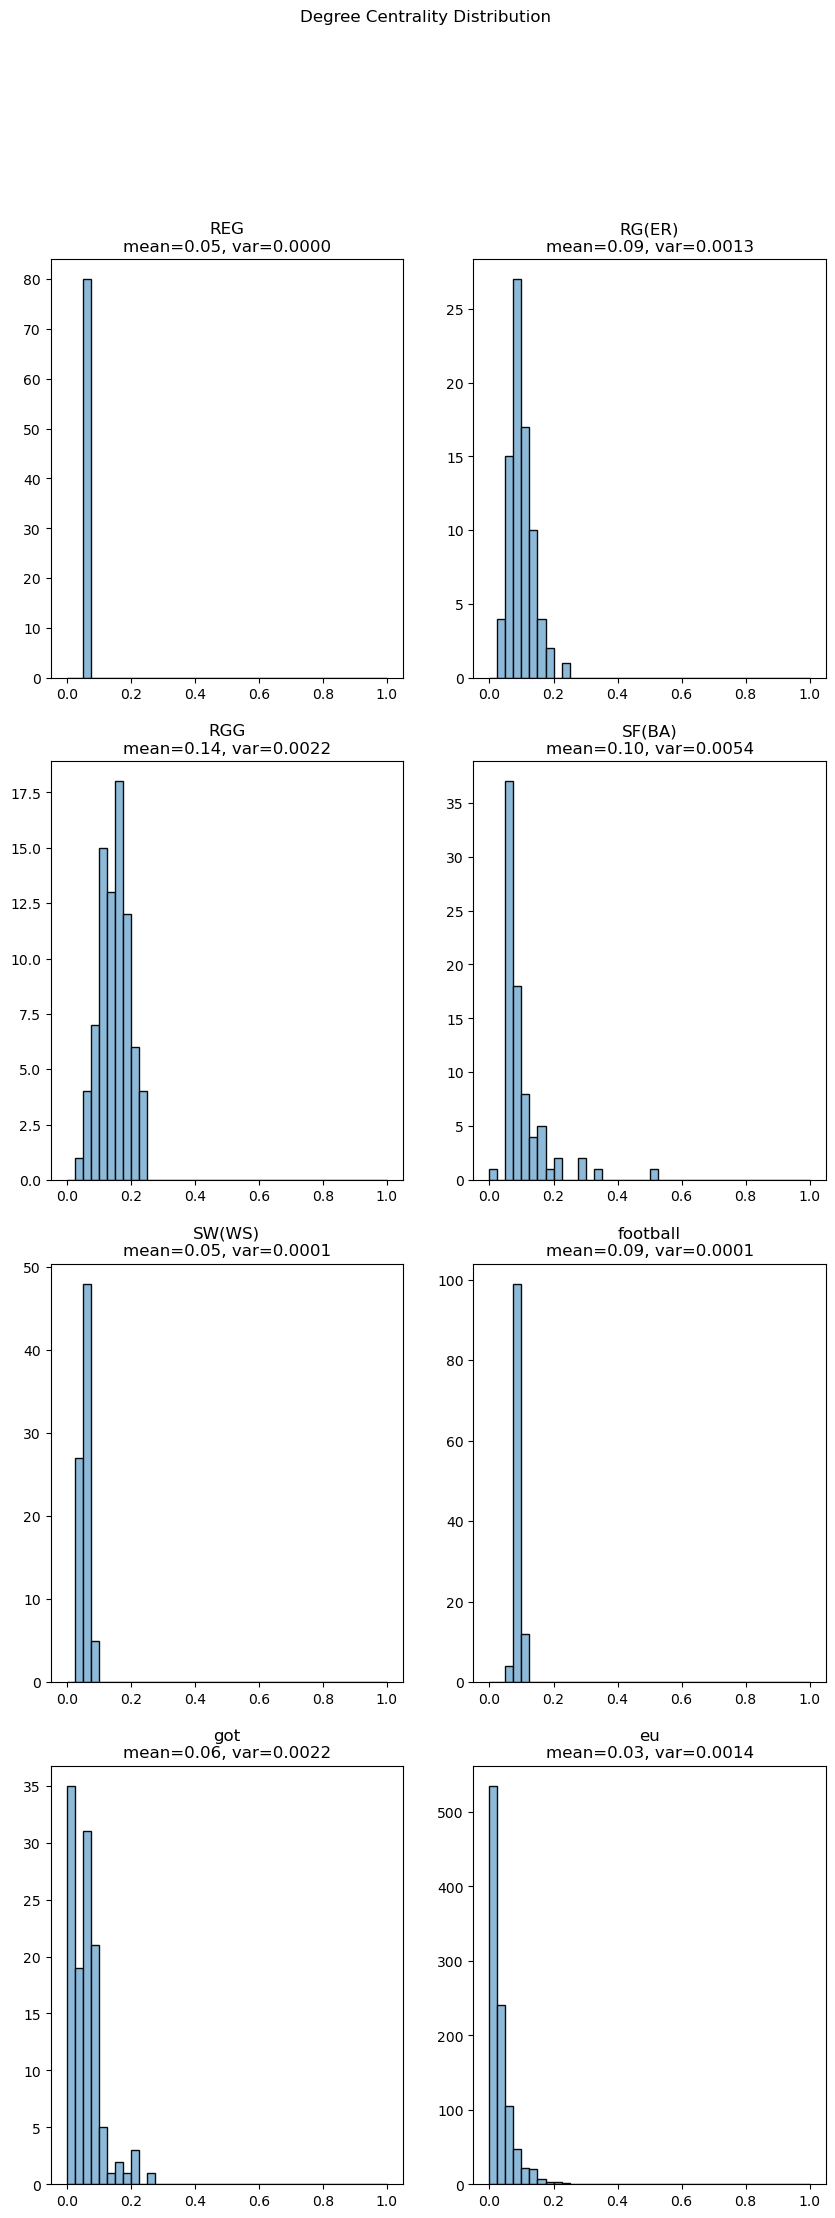

In [7]:
plot_grid(graphs, plot_centrality_distribution(nx.degree_centrality), 'Degree Centrality Distribution')
plt.show()

#### Σχόλιο

Η κατανομή βαθμού του `football` μοιάζει με small-world, του `got` μοιάζει με scale-free, ενώ του `eu` φαίνεται να ακολουθεί εκθετική κατανομή (όχι power law / scale-free).

<h4>Μελέτη συντελεστή ομαδοποίησης για πραγματικές και συνθετικές τοπολογίες</h4>

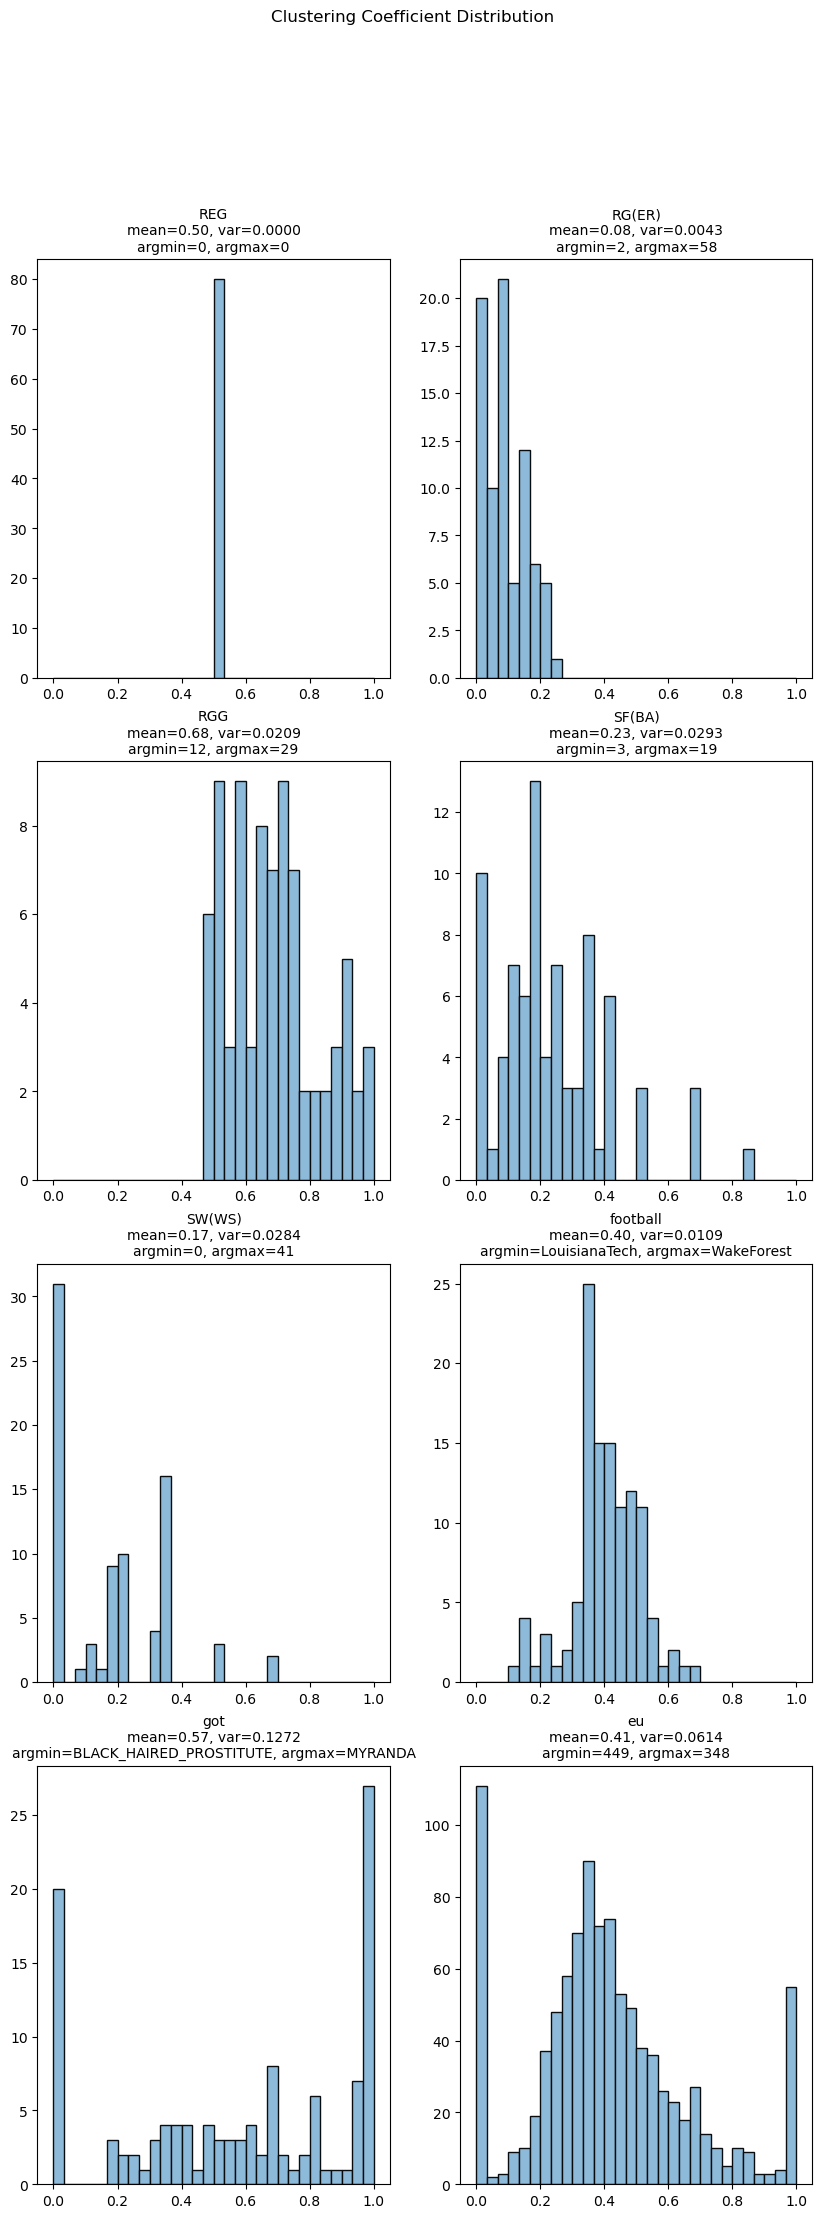

In [8]:
plot_grid(graphs, plot_clustering_coefficient_distribution, 'Clustering Coefficient Distribution')
plt.show()

#### Σχόλιο

Οι κατανομή του `eu` μοιάζει λίγο με του scale-free.

<h4>Μελέτη κεντρικότητας εγγύτητας για πραγματικές και συνθετικές τοπολογίες </h4>

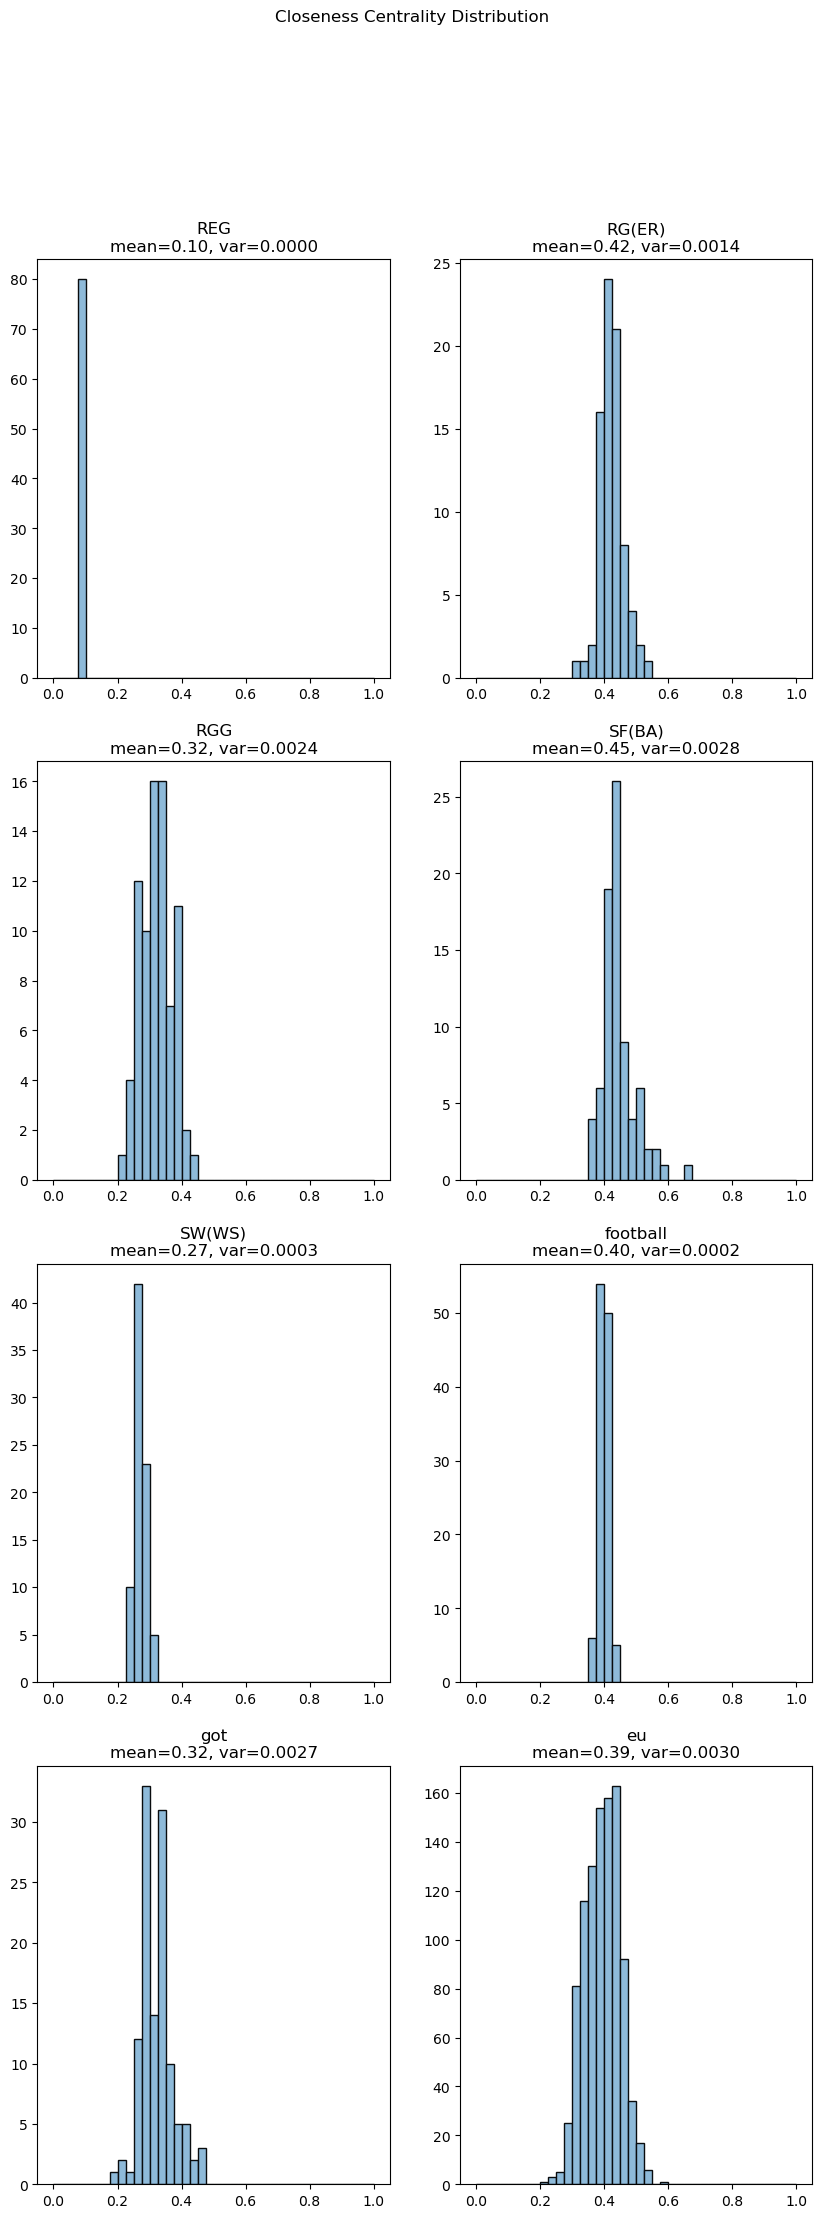

In [9]:
plot_grid(graphs, plot_centrality_distribution(nx.closeness_centrality), 'Closeness Centrality Distribution')
plt.show()

#### Σχόλιο

Δεν φαίνεται να υπάρχει κάποια συσχέτιση.

<h3>B. Εξοικείωση με τα εργαλεία εντοπισμού κοινοτήτων</h3>
<ol>
<li>Χρησιμοποιώντας τις συναρτήσεις του <b>πίνακα 2</b> για κάθε <u>πραγματικό</u> (<b>πίνακας 1</b>) και <u>συνθετικό</u> (από την <b>άσκηση 1</b>) δίκτυο:</p>
<ol>
    <li>να οπτικοποιηθούν οι κοινότητες που προκύπτουν από την κάθε μέθοδο,</li>
    <li>να γίνουν οι απαραίτητοι σχολιασμοί (π.χ: σύγκριση του αριθμού των κοινοτήτων που υπολογίζει ο κάθε αλγόριθμος).</li>
</ol>
<p>Για την οπτικοποίηση, να επισημανθεί διαφορετικά κάθε κοινότητα, π.χ. με διαφορετικό χρώμα.</p>
<p style=text-align:justify>Στην περίπτωση των συνθετικών δικτύων, να πραγματοποιηθούν συγκρίσεις και μεταξύ των διαφορετικών τύπων τοπολογιών. Για παράδειγμα, στην περίπτωση του τυχαίου γεωμετρικού γράφου, υπάρχει διαισθητικά μία κοινότητα γύρω από κάθε κόμβο που δημιουργείται με βάση τις αποστάσεις του τελευταίου από τους υπόλοιπους κόμβους του δικτύου. Στην περίπτωση των scale-free δικτύων, είναι πιθανό να σχηματίζονται κοινότητες γύρω από τους κόμβους με μεγάλο βαθμό.</p>
<li>Για κάθε αλγόριθμο εντοπισμού κοινοτήτων και για κάθε τοπολογία αξιολογήστε την ποιότητα της διαμέρισης με τις μετρικές performance και modularity (<a style=text-decoration:none href='https://networkx.org/documentation/stable/reference/algorithms/community.html#module-networkx.algorithms.community.quality'>measuring_partitions</a>). Για την μετρική performance, θα χρησιμοποιήσετε την συνάρτηση partition_quality του networkx.</li>
<li>Για την μεγαλύτερη συνδεδεμένη συνιστώσα του email-Eu-core, να συγκρίνετε την ground-truth διαμέριση που δίνεται στο αρχείο Email-Eu-core-department-labels.txt με τις διαμερίσεις που προκύπτουν από τις εξεταζόμενες μεθόδους ως προς το πλήθος των παραγόμενων κοινοτήτων και ως προς τις μετρικές performance και modularity. </li>
<li>Για την παρακολούθηση του χρόνου εκτέλεσης της υλοποίησής σας, μπορείτε να χρησιμοποιήσετε την βιβλιοθήκη <a style=text-decoration:none href='https://tqdm.github.io/'>tqdm</a>. Στο σχολιασμό σας να λάβετε υπόψη το trade-off της ποιότητας της διαμέρισης και του χρόνου εκτέλεσης των εξεταζόμενων αλγορίθμων. </li>
</ol>

<table style=float:left;width:70%>
    <caption>Πίνακας <b>2</b>: Συναρτήσεις εντοπισμού κοινοτήτων</caption>
    <tr>
        <th style=text-align:left> Μέθοδος εντοπισμού κοινοτήτων</th>
        <th style=text-align:left>Συνάρτηση</th>
    </tr>
    <tr>
        <td style=text-align:left>Spectral Clustering</td>
        <td style=text-align:left><a style=text-decoration:none href='http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html'>SpectralClustering</a></td>
    </tr>
       <tr>
        <td style=text-align:left>Newman-Girvan</td>
        <td style=text-align:left><a style=text-decoration:none                               href='https://networkx.github.io/documentation/latest/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html'>girvan_newman</a></td>
    </tr>
    <tr>
        <td style=text-align:left>Modularity Maximization</td>
        <td style=text-align:left><a style=text-decoration:none                               href='https://networkx.github.io/documentation/latest/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html'>greedy_modularity_communities</a></td>
    </tr>
</table>
    

<p style=text-align:justify>Προτού εφαρμόσετε τις συναρτήσεις εντοπισμού κοινοτήτων μελετήστε προσεκτικά την <b>είσοδο που απαιτούν καθώς και τη μορφή εξόδου που παράγουν.</b></p>

In [10]:
# #Χρησιμοποιήστε την συνάρτηση conv2int για να μετατρέψετε τα labels των κόμβων στις πραγματικές τοπολογίες σε integers

# def conv2int(G, start_value):
#     nG = nx.convert_node_labels_to_integers(G, first_label=start_value)
#     G_mapping = dict(enumerate(G.nodes))
#     return nG, G_mapping

<h4> Ορισμός χρωμάτων για την οπτικοποίηση των κοινοτήτων.</h4>

In [11]:
# #insert colors for nodes
# from matplotlib import colors as mcolors

# colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())

<h4>Εντοπισμός κοινοτήτων σε συνθετικά και πραγματικά δίκτυα με τη μέθοδο Newman-Girvan.</h4>
<p>Παράξτε τις διαμερίσεις που προκύπτουν από την μέθοδο Newman-Girvan. Ελέγξτε τις διαμερίσεις που έχουν μέχρι και 50 κοινότητες.</p> 
<p> Επιλέξτε τις διαμερίσεις με το 1) μεγαλύτερο modularity score και 2) performance score για κάθε πραγματικό και συνθετικό δίκτυο.</p>

In [12]:
def girvan_newman_50(G):
    return takewhile(lambda communities: len(communities) <= 50, girvan_newman(G))


def best_partition(G, algorithm, score_fn):
    # return max(algorithm(G), key=functools.partial(score_fn, G))
    partition_sizes = []
    times = []
    scores = []
    best_score = float('-Infinity')

    t = time.perf_counter()
    for partition in algorithm(G):
        dt = time.perf_counter() - t

        score = score_fn(G, partition)
        if score > best_score:
            best_score = score
            best_part = partition

        partition_sizes.append(len(partition))
        times.append(dt)
        scores.append(score)

        t = time.perf_counter()

    return dict(best_partition=best_part, partition_sizes=partition_sizes, scores=scores, times=times)


best_partition_gn = {
    name: {score_fn.__name__: best_partition(G, girvan_newman_50, score_fn) for score_fn in (modularity, performance)
          } for name, G in graphs.items()
}

<h4>Εντοπισμός κοινοτήτων σε συνθετικά και πραγματικά δίκτυα με τη μέθοδο Spectral Clustering. </h4>
Προσοχή! Για την επιλογή της τιμής της παραμέτρου που αφορά στην διάσταση του projection subspace (n_clusters) της συνάρτησης SpectralClustering, θα πρέπει να λάβετε υπόψη το μέγεθος |V| του εκάστοτε δικτύου.
<p>Να εξετάσετε τις διαμερίσεις που προκύπτουν για n_clusters$=2,...,50 Να επιλέξετε για οπτικοποίηση τις διαμερίσεις με το 1) μεγαλύτερο modularity score και 2) performance score για κάθε πραγματικό και συνθετικό δίκτυο.</p>

In [13]:
def spectral_clustering(G, n_clusters):
    adjacency_matrix = csr_matrix(nx.to_scipy_sparse_array(G))
    clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
    clustering.fit(adjacency_matrix)

    communities = tuple(set() for _ in range(n_clusters))
    for node, label in zip(G.nodes, clustering.labels_):
        communities[label].add(node)

    return communities


def spectral_clustering_50(G):
    for n_clusters in range(2, 51):
        yield spectral_clustering(G, n_clusters)


best_partition_sc = {
    name:
    {score_fn.__name__: best_partition(G, spectral_clustering_50, score_fn) for score_fn in (modularity, performance)}
    for name, G in graphs.items()
}

<h4>Εντοπισμός κοινοτήτων σε συνθετικά και πραγματικά δίκτυα με τη μέθοδο Modularity Maximization.</h4>
Για την διαμέριση που θα προκύψει σε κάθε συνθετικό και πραγματικό δίκτυο, να υπολογίσετε το modularity score και το performance score.

In [14]:
partition_mm = {name: greedy_modularity_communities(G) for name, G in graphs.items()}

In [15]:
# import pickle

# with open('partition_mm.pkl', 'wb') as f:
#     pickle.dump(partition_mm, f)

# with open('best_partition_sc.pkl', 'wb') as f:
#     pickle.dump(best_partition_sc, f)

# with open('best_partition_gn.pkl', 'wb') as f:
#     pickle.dump(best_partition_gn, f)

In [16]:
# import pickle

# with open('partition_mm.pkl', 'rb') as f:
#     partition_mm = pickle.load(f)

# with open('best_partition_sc.pkl', 'rb') as f:
#     best_partition_sc = pickle.load(f)

# with open('best_partition_gn.pkl', 'rb') as f:
#     best_partition_gn = pickle.load(f)

#### Οπτικοποίηση κοινοτήτων American College Football

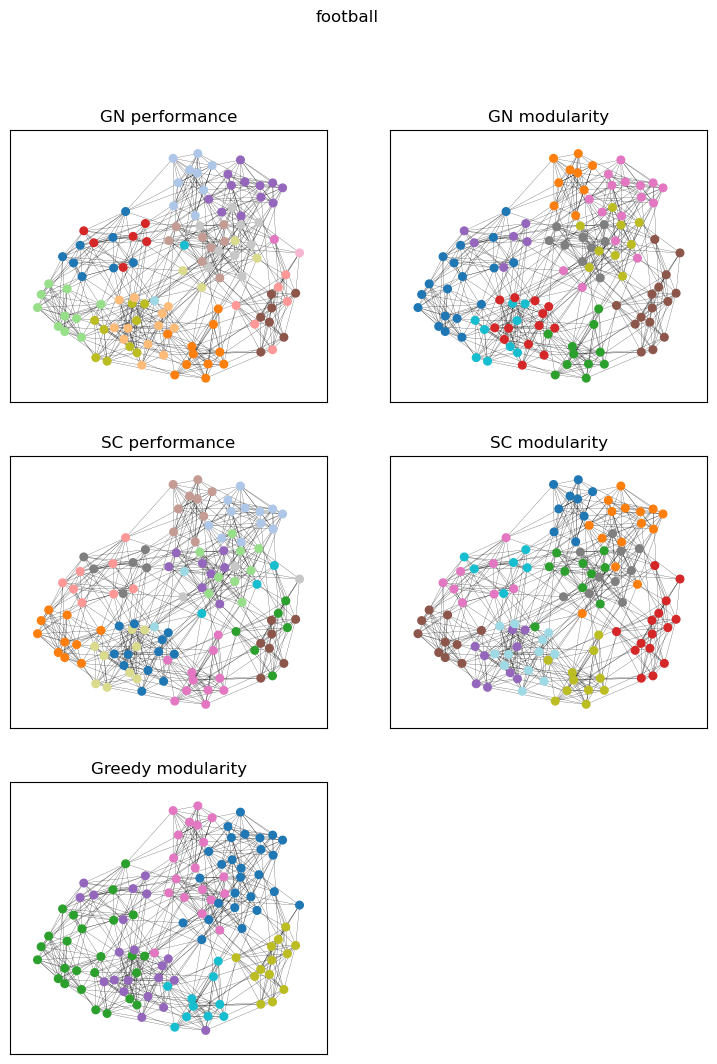

In [17]:
def plot_communities(G: nx.Graph, partition, title=None, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    node_to_int = {node: i for i, node in enumerate(G.nodes)}

    colors = [None] * len(G)
    for color, community in enumerate(partition):
        for node in community:
            colors[node_to_int[node]] = color

    cmap = 'tab10' if len(partition) <= 10 else 'tab20'
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx(
        G, pos=pos, node_color=colors, with_labels=False, node_size=30, width=0.15, alpha=1.0, cmap=cmap, ax=ax
    )
    ax.set_title(title)


def plot_communities_grid(name, suptitle=None):
    G = graphs[name]

    fig, axs = plt.subplots(3, 2, figsize=(9, 12))

    plot_communities(G, best_partition_gn[name]['performance']['best_partition'], f"GN performance", ax=axs[0, 0])
    plot_communities(G, best_partition_gn[name]['modularity']['best_partition'], f"GN modularity", ax=axs[0, 1])

    plot_communities(G, best_partition_sc[name]['performance']['best_partition'], f"SC performance", ax=axs[1, 0])
    plot_communities(G, best_partition_sc[name]['modularity']['best_partition'], f"SC modularity", ax=axs[1, 1])

    plot_communities(G, partition_mm[name], f"Greedy modularity", ax=axs[2, 0])

    axs[2, 1].axis('off')

    fig.suptitle(suptitle if suptitle is not None else name)


plot_communities_grid('football')

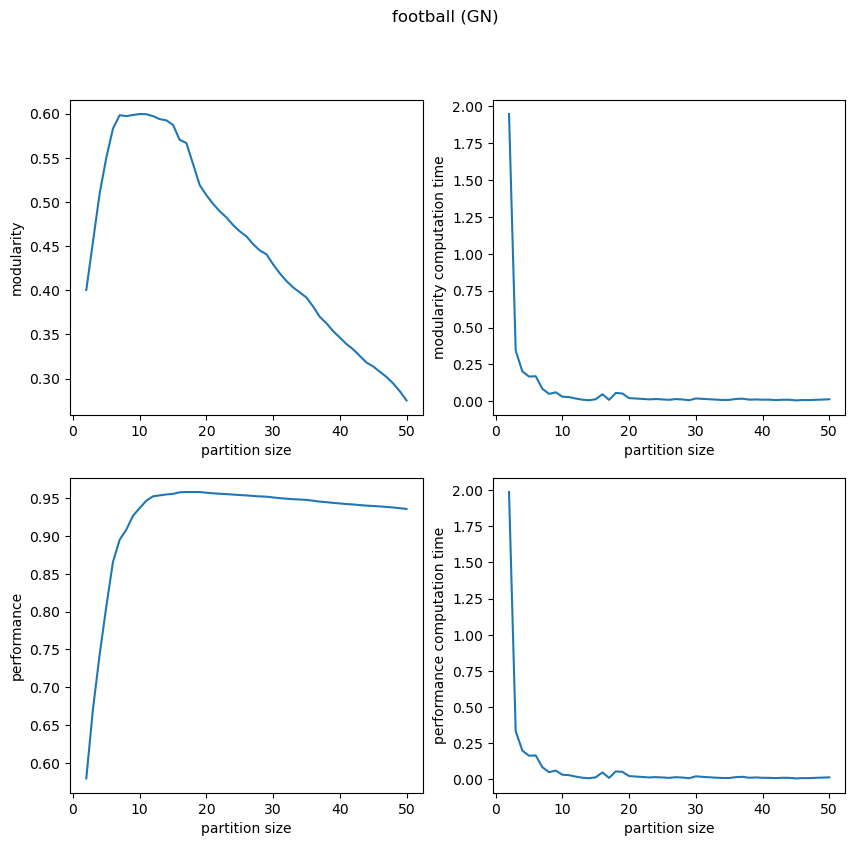

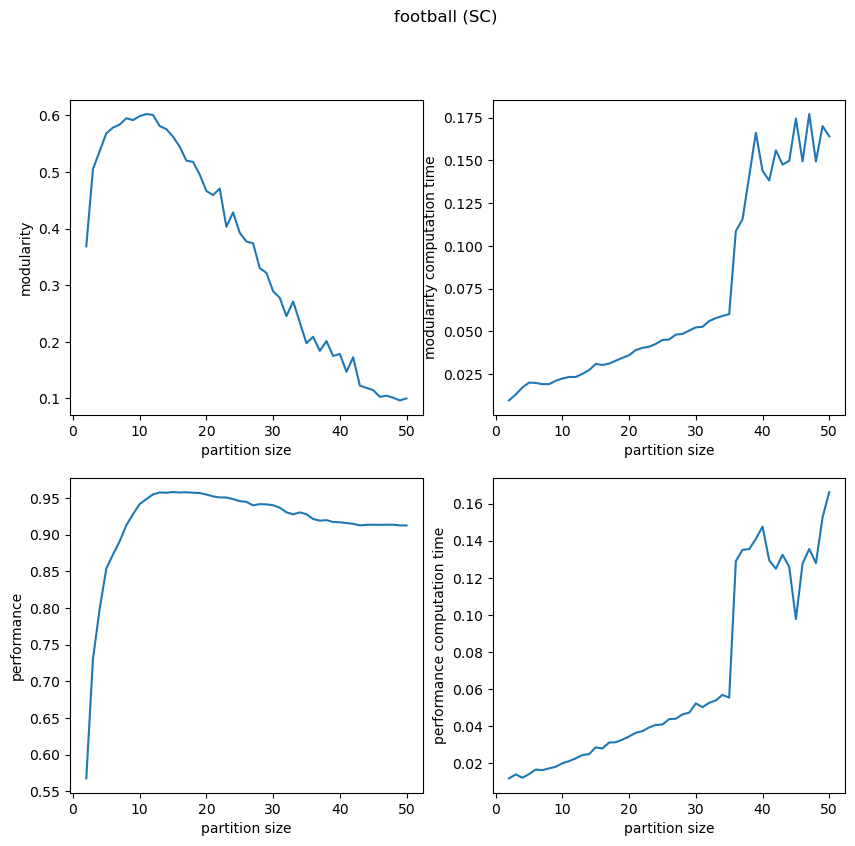

In [18]:
def plot_history(history, title=None):
    fig, axss = plt.subplots(2, 2, figsize=(10, 9))

    for (metric, history), axs in zip(history.items(), axss):
        axs[0].plot(history['partition_sizes'], history['scores'])
        axs[0].set_xlabel('partition size')
        axs[0].set_ylabel(metric)

        axs[1].plot(history['partition_sizes'], history['times'])
        axs[1].set_xlabel('partition size')
        axs[1].set_ylabel(f'{metric} computation time')

    fig.suptitle(title)
    return axs


key = 'football'
plot_history(best_partition_gn[key], f'{key} (GN)')
plot_history(best_partition_sc[key], f'{key} (SC)')
plt.show()

#### Οπτικοποίηση κοινοτήτων Game of Thrones

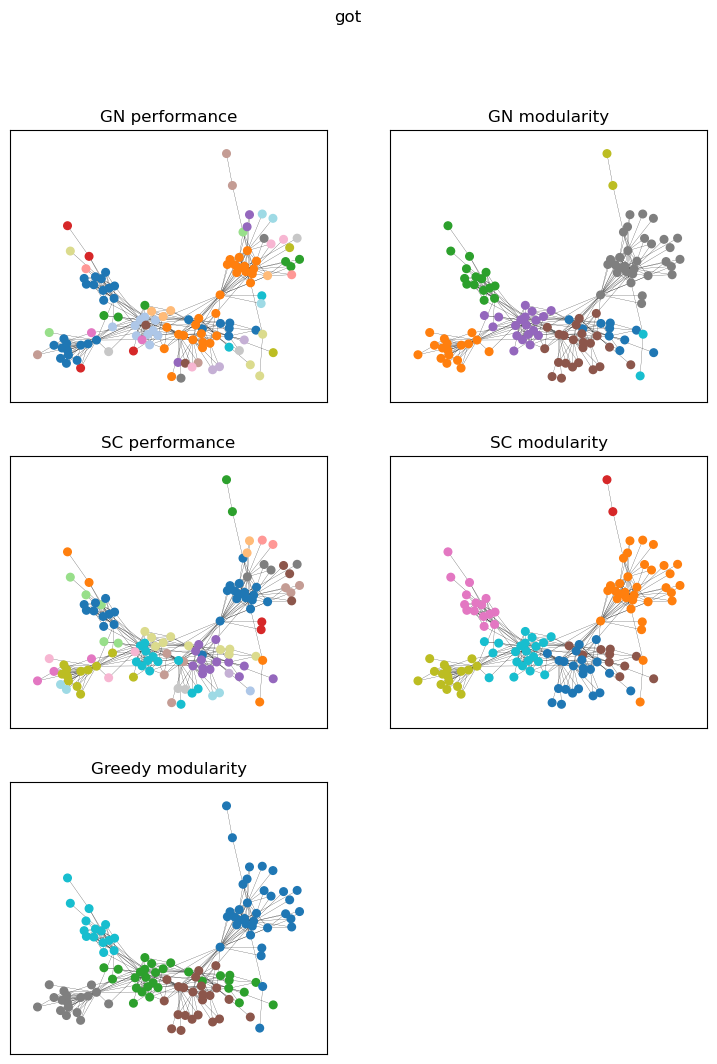

In [19]:
plot_communities_grid('got')

#### Οπτικοποίηση κοινοτήτων email-Eu-core (να οπτικοποιηθεί και η ground-truth διαμέριση)

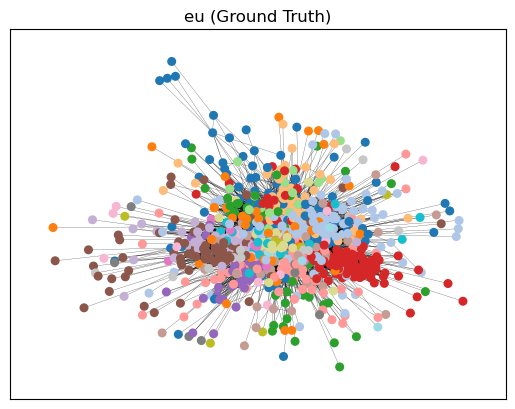

In [20]:
def plot_eu_gt():
    with open('email-Eu-core-department-labels.txt') as f:
        gt = [int(s.split(' ')[1]) for s in f.readlines()]

    partition = [set() for _ in range(max(gt) + 1)]

    for i, color in enumerate(gt):
        node = str(i)
        if node in graphs['eu']:
            partition[color].add(str(node))

    partition = [community for community in partition if community]

    plot_communities(graphs['eu'], partition, 'eu (Ground Truth)')


plot_eu_gt()

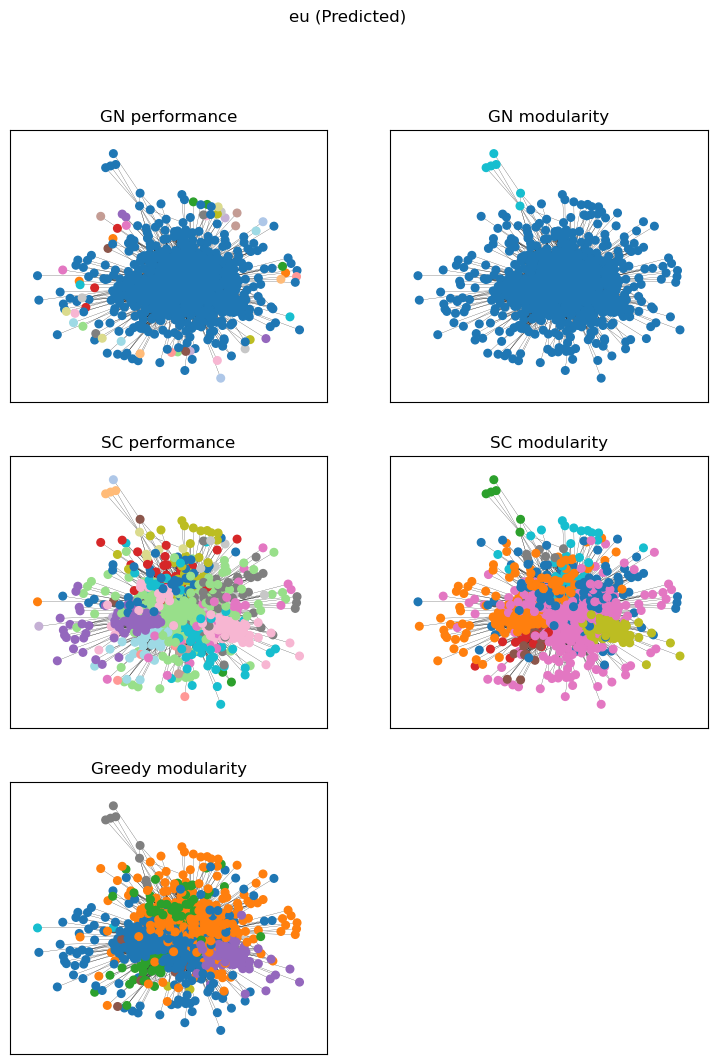

In [21]:
plot_communities_grid('eu', 'eu (Predicted)')

#### Οπτικοποίηση κοινοτήτων REG

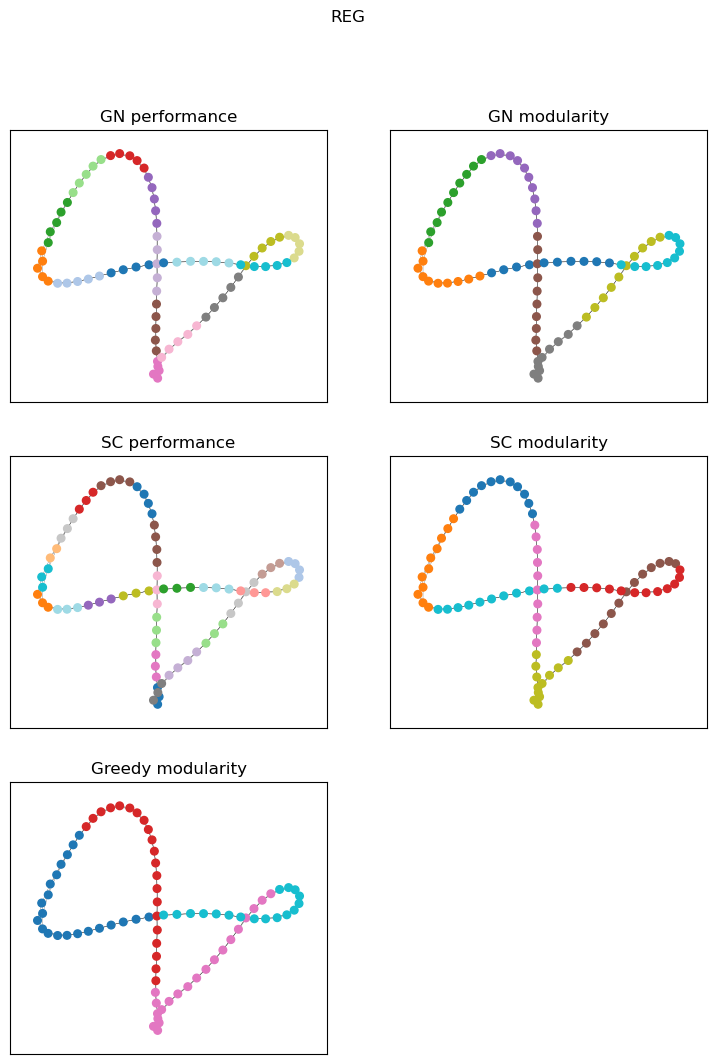

In [22]:
plot_communities_grid('REG')

#### Οπτικοποίηση κοινοτήτων RGER

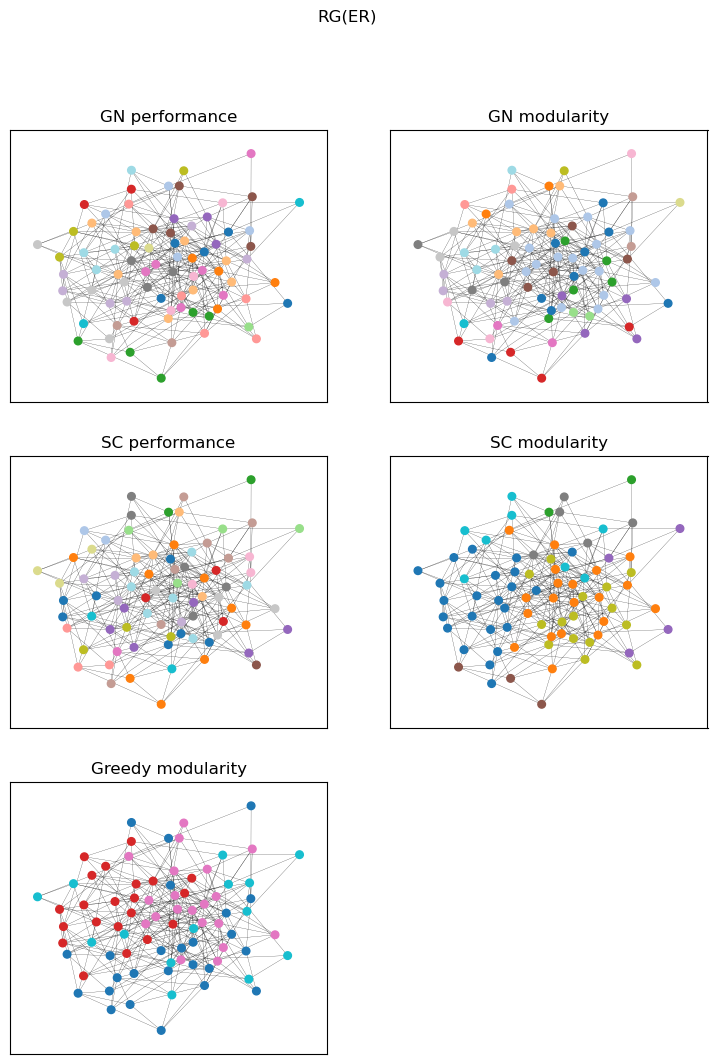

In [23]:
plot_communities_grid('RG(ER)')

#### Οπτικοποίηση κοινοτήτων RGG

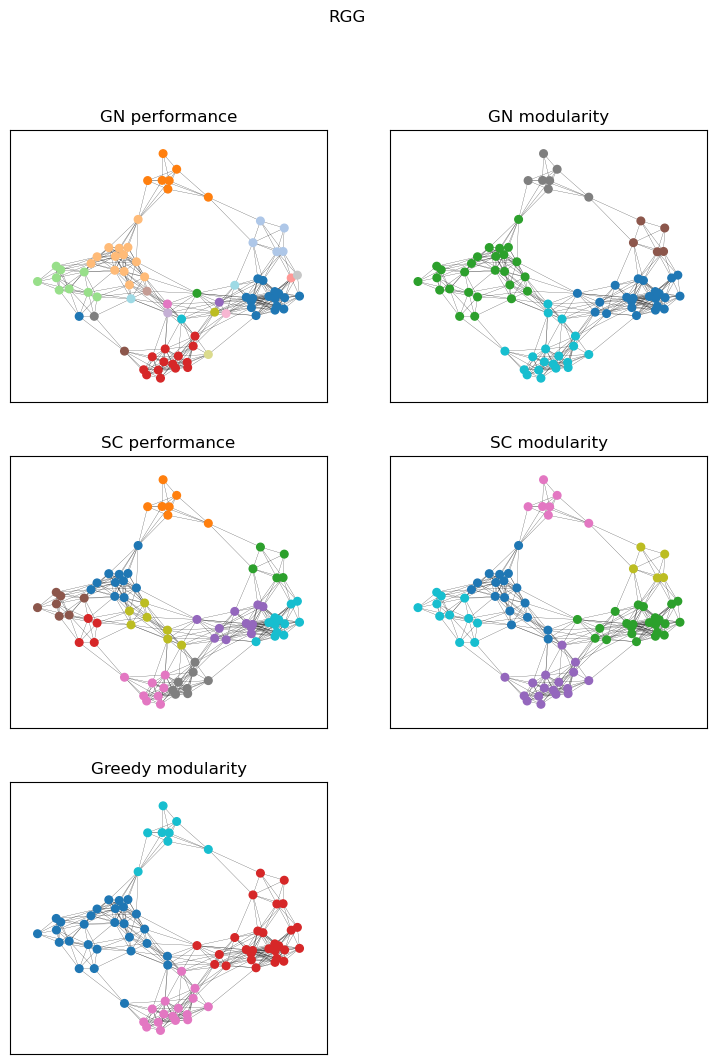

In [24]:
plot_communities_grid('RGG')

#### Οπτικοποίηση κοινοτήτων SW

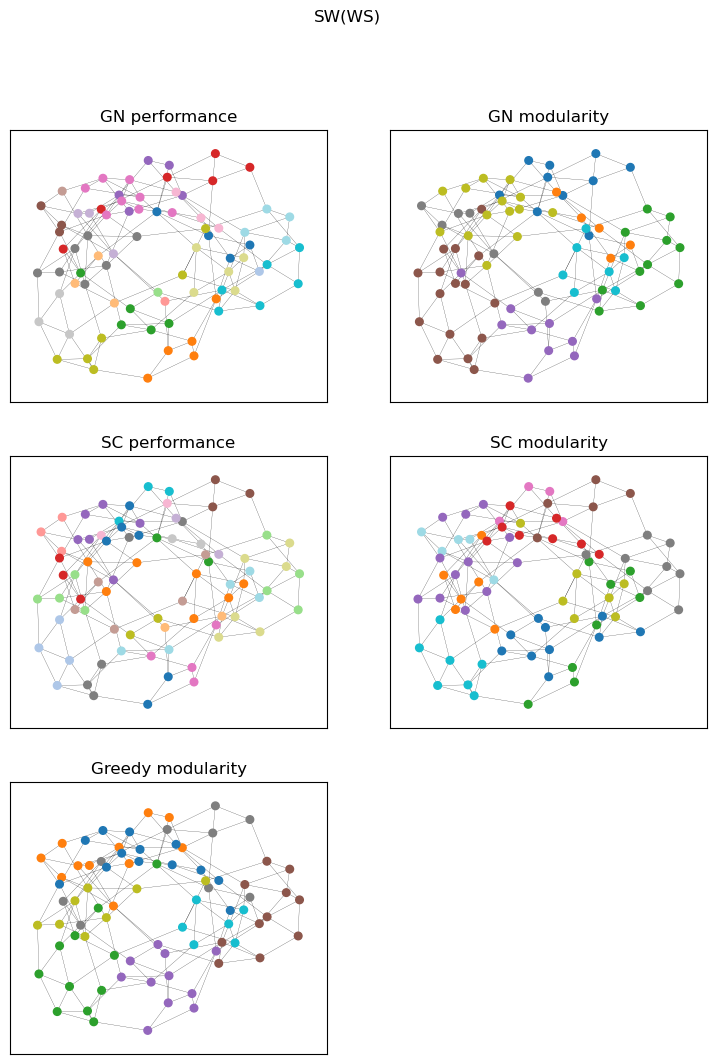

In [25]:
plot_communities_grid('SW(WS)')

#### Οπτικοποίηση κοινοτήτων SF

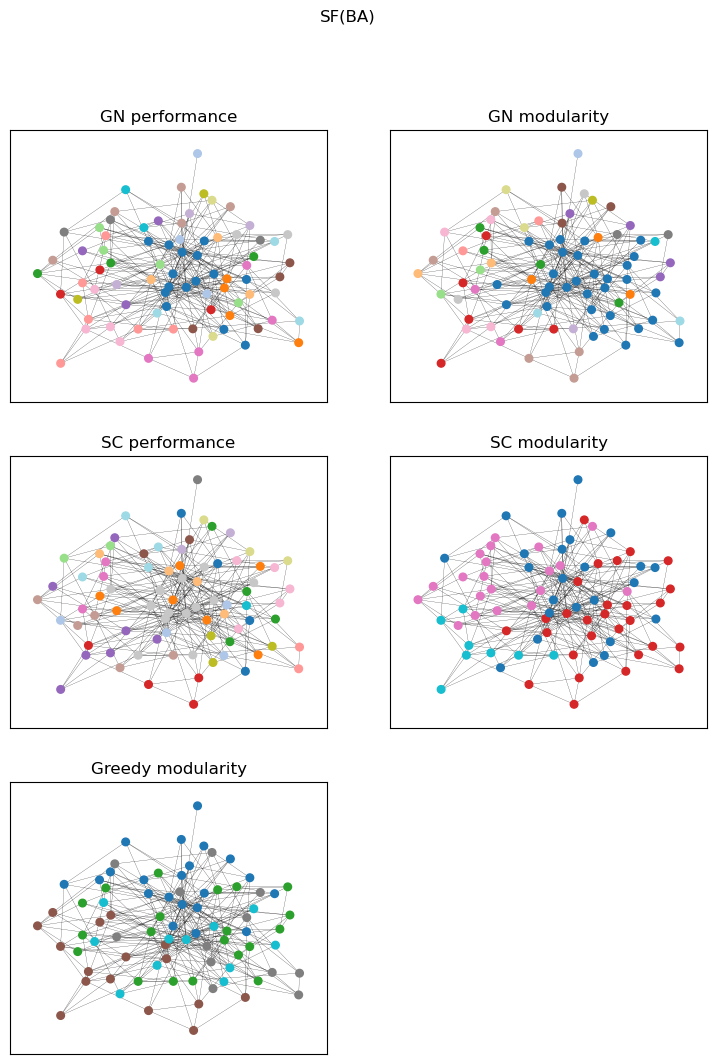

In [26]:
plot_communities_grid('SF(BA)')